In [ ]:
#pip install memory_profiler

Generation 0: Average Fitness - 0.7727272727272728, Average Accuracy - 0.7727272727272728, Average Precision - 0.7272727272727272, Average Sensitivity - 0.5818181818181818
Time taken for generation 1: 0.0060961246490478516 seconds
Generation 1: Average Fitness - 0.7727272727272728, Average Accuracy - 0.7727272727272728, Average Precision - 0.7272727272727272, Average Sensitivity - 0.5818181818181818
Time taken for generation 2: 0.015747785568237305 seconds
Memory Usage 2: 0.0078125 


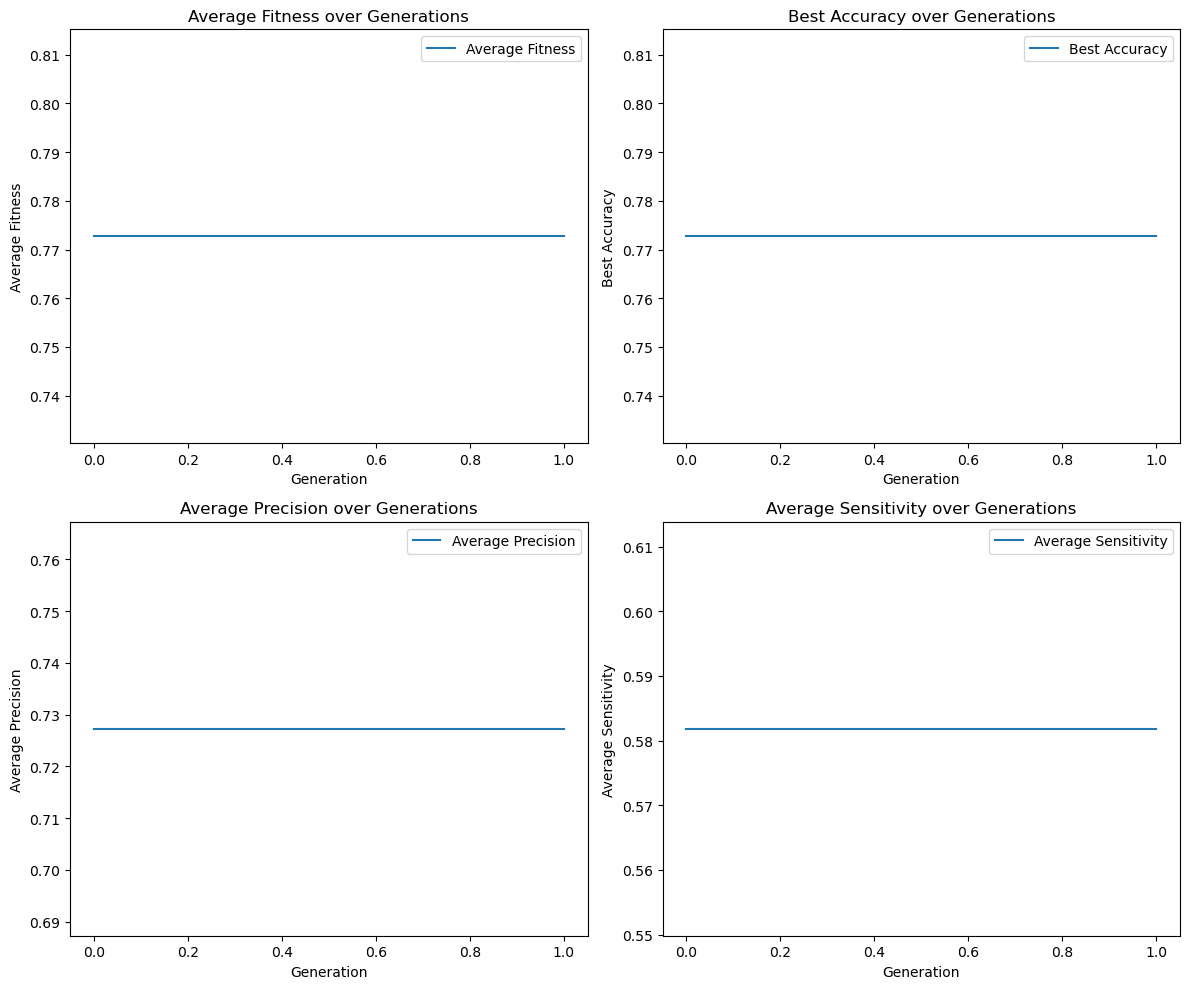

Generation 0:
  Parent 1: Fitness - 0.7727272727272727
  Parent 2: Fitness - 0.7727272727272727

  Parent nodes - 5, 1, 
    Child 1: Fitness - 0.7727272727272727, 
    Precision - 0.7272727272727273, 
    Sensitivity - 0.5818181818181818, 

  Parent nodes - 1, 5, 
    Child 2: Fitness - 0.7727272727272727, 
    Precision - 0.7272727272727273, 
    Sensitivity - 0.5818181818181818 

---------------------------------------------------------------
Avarage Fitness for all generations:  77.27272727272728
Avarage Accuracy for all generations:  77.27272727272728
Avarage precision for all generations:  72.72727272727272
Avarage Time for all generations:  72.72727272727272  in seconds.


Generation 1:
  Parent 1: Fitness - 0.7727272727272727
  Parent 2: Fitness - 0.7727272727272727

  Parent nodes - 0, 0, 
    Child 1: Fitness - 0.7727272727272727, 
    Precision - 0.7272727272727273, 
    Sensitivity - 0.5818181818181818, 

  Parent nodes - 0, 0, 
    Child 2: Fitness - 0.7727272727272727, 
 

In [64]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
import random
import matplotlib.pyplot as plt

import time
from memory_profiler import memory_usage


# Function to read CSV file
def read_data(file_path):
    data = pd.read_csv(file_path)
    X = data.iloc[:, :-1].values
    y = data.iloc[:, -1].values
    return X, y

# Function to generate initial population
def initialize_population(population_size, max_depth):
    population = []
    for _ in range(population_size):
        tree = DecisionTreeClassifier(max_depth=max_depth)
        population.append(tree)
    return population

# Fitness function and evaluation
def evaluate_fitness(tree, X_train, y_train, X_test, y_test):
    tree.fit(X_train, y_train)
    predictions = tree.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    confusion = confusion_matrix(y_test, predictions)
    return accuracy, precision, recall, confusion

# Tournament selection
def tournament_selection(population, fitness_scores, tournament_size):
    selected = []
    for _ in range(len(population)):
        participants = random.sample(range(len(population)), tournament_size)
        winner = max(participants, key=lambda x: fitness_scores[x])
        selected.append(population[winner])
    return selected

# Crossover
def crossover(parent1, parent2):
    tree1 = parent1.tree_
    tree2 = parent2.tree_
    nodes1 = np.random.randint(0, tree1.node_count)
    nodes2 = np.random.randint(0, tree2.node_count)
    child1 = DecisionTreeClassifier(max_depth=parent1.max_depth)
    child2 = DecisionTreeClassifier(max_depth=parent2.max_depth)
    child1.tree_ = crossover_subtrees(tree1, nodes1, tree2, nodes2)
    child2.tree_ = crossover_subtrees(tree2, nodes2, tree1, nodes1)
    return child1, child2, nodes1, nodes2

def crossover_subtrees(tree1, node1, tree2, node2):
    temp = tree1.children_left[node1]
    tree1.children_left[node1] = tree2.children_left[node2]
    tree2.children_left[node2] = temp
    temp = tree1.children_right[node1]
    tree1.children_right[node1] = tree2.children_right[node2]
    tree2.children_right[node2] = temp
    return tree1

# Mutation
def mutation(tree, mutation_rate):
    if random.uniform(0, 1) < mutation_rate:
        node_to_mutate = np.random.randint(0, tree.tree_.node_count)
        if random.uniform(0, 1) < 0.5:
            tree.tree_.children_left[node_to_mutate] = np.random.randint(0, tree.tree_.node_count)
        else:
            tree.tree_.children_right[node_to_mutate] = np.random.randint(0, tree.tree_.node_count)
    return tree

# Generate new generation
def generate_new_generation(population, fitness_scores, tournament_size, mutation_rate):
    new_generation = tournament_selection(population, fitness_scores, tournament_size)
    parents_indices = []
    children = []
    for _ in range(len(new_generation)//2):
        parent_indices = random.sample(range(len(new_generation)), 2)
        parents_indices.append(parent_indices)
        parent1, parent2 = new_generation[parent_indices[0]], new_generation[parent_indices[1]]
        child1, child2, parent1_node, parent2_node = crossover(parent1, parent2)
        child1 = mutation(child1, mutation_rate)
        child2 = mutation(child2, mutation_rate)
        children.append((child1, child2, parent1_node, parent2_node))
    return new_generation, parents_indices, children

# Main function
def genetic_programming(X, y, max_depth, population_size, tournament_size, mutation_rate, generations):
    
    memory_usage_start = memory_usage(max_usage=True)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    population = initialize_population(population_size, max_depth)
    gen_fitness = []
    gen_accuracy = []
    gen_precision = []
    gen_sensitivity = []
    gen_parents = []
    gen_children = []

    for generation in range(generations):
        start_time = time.time()

        fitness_scores = []
        precisions = []
        sensitivities = []
        conf_matrices = []
        for tree in population:
            accuracy, precision, sensitivity, confusion = evaluate_fitness(tree, X_train, y_train, X_test, y_test)
            fitness_scores.append(accuracy)
            precisions.append(precision)
            sensitivities.append(sensitivity)
            conf_matrices.append(confusion)

        average_fitness = np.mean(fitness_scores)
        average_precision = np.mean(precisions)
        average_sensitivity = np.mean(sensitivities)
        average_accuracy = np.mean(fitness_scores)
        
        #best_tree_index = fitness_scores.index(best_accuracy)
        #best_tree = population[best_tree_index]
        print(f"Generation {generation}: Average Fitness - {average_fitness}, "
              f"Average Accuracy - {average_accuracy}, "
              f"Average Precision - {average_precision}, "
              f"Average Sensitivity - {average_sensitivity}")
        
        gen_fitness.append(average_fitness)
        gen_accuracy.append(average_accuracy)
        gen_precision.append(average_precision)
        gen_sensitivity.append(average_sensitivity)

        population, parents, children = generate_new_generation(population, fitness_scores, tournament_size, mutation_rate)
        gen_parents.append(parents)
        gen_children.append(children)

        end_time = time.time()
        print(f"Time taken for generation {generation + 1}: {end_time - start_time} seconds")
        
    memory_usage_end = memory_usage(max_usage=True)
    print(f"Memory Usage {generation + 1}: {memory_usage_end - memory_usage_start} ")

    # Plotting results
    plt.figure(figsize=(12, 10))
    plt.subplot(2, 2, 1)
    plt.plot(range(generations), gen_fitness, label='Average Fitness')
    plt.xlabel('Generation')
    plt.ylabel('Average Fitness')
    plt.title('Average Fitness over Generations')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(range(generations), gen_accuracy, label='Best Accuracy')
    plt.xlabel('Generation')
    plt.ylabel('Best Accuracy')
    plt.title('Best Accuracy over Generations')
    plt.legend()

    plt.subplot(2, 2, 3)
    plt.plot(range(generations), gen_precision, label='Average Precision')
    plt.xlabel('Generation')
    plt.ylabel('Average Precision')
    plt.title('Average Precision over Generations')
    plt.legend()

    plt.subplot(2, 2, 4)
    plt.plot(range(generations), gen_sensitivity, label='Average Sensitivity')
    plt.xlabel('Generation')
    plt.ylabel('Average Sensitivity')
    plt.title('Average Sensitivity over Generations')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Printing parents and children
    for gen in range(generations):
        print(f"Generation {gen}:")
        for i, (parent1_idx, parent2_idx) in enumerate(gen_parents[gen]):
            parent1 = population[parent1_idx]
            parent2 = population[parent2_idx]
            print(f"  Parent {i + 1}: Fitness - {fitness_scores[parent1_idx]}")
            print(f"  Parent {i + 2}: Fitness - {fitness_scores[parent2_idx]}")
            child1, child2, parent1_node, parent2_node = gen_children[gen][i]
            print(f"\n  Parent nodes - {parent1_node}, {parent2_node}, "
                  f"\n    Child {i + 1}: Fitness - {evaluate_fitness(child1, X_train, y_train, X_test, y_test)[0]}, "
                  f"\n    Precision - {evaluate_fitness(child1, X_train, y_train, X_test, y_test)[1]}, "
                  f"\n    Sensitivity - {evaluate_fitness(child1, X_train, y_train, X_test, y_test)[2]}, ")
                  
            print(f"\n  Parent nodes - {parent2_node}, {parent1_node}, "
                  f"\n    Child {i + 2}: Fitness - {evaluate_fitness(child2, X_train, y_train, X_test, y_test)[0]}, "
                  f"\n    Precision - {evaluate_fitness(child2, X_train, y_train, X_test, y_test)[1]}, "
                  f"\n    Sensitivity - {evaluate_fitness(child2, X_train, y_train, X_test, y_test)[2]} \n")
            print("---------------------------------------------------------------")

        #print(f"\nConfusion matrix for generation {gen}:")
        #print("Predicted Positive | Actual Positive | Actual Negative")
        #print(conf_matrices[gen][1, 1], "|", conf_matrices[gen][1, 0], "|", conf_matrices[gen][1, 1])
        #print(conf_matrices[gen][0, 1], "|", conf_matrices[gen][0, 0], "|", conf_matrices[gen][0, 1])

        total_fitness = 0
        total_Accuracy = 0
        total_precision = 0
        total_time = 0
        total_memory = 0
        
        Av_total_fitness = 0
        Av_gen_accuracy = 0
        Av_gen_precision = 0
        Av_time = 0
        Av_memory = 0


        for m in range(generation):
            total_fitness += gen_fitness[m]
            total_Accuracy += gen_accuracy[m]
            total_precision += gen_precision[m]
            total_time += gen_precision[m]
            total_memory += gen_precision[m]

        Av_total_fitness = (total_fitness * 100) / generation
        print("Avarage Fitness for all generations: ", Av_total_fitness)

        Av_gen_accuracy = (total_Accuracy * 100) /  generation
        print("Avarage Accuracy for all generations: ", Av_gen_accuracy)

        Av_gen_precision = (total_precision * 100) / generation
        print("Avarage precision for all generations: ", Av_gen_precision)
        
        Av_time = (total_time * 100) / generation
        print("Avarage Time for all generations: ", Av_time, " in seconds.\n\n")
        
        
    return best_tree, population, gen_fitness

# Function to print individuals of the last generation
def print_last_generation_individuals(population, fitness_scores):
    print("Individuals of the Last Generation:")
    for idx, (tree, fitness) in enumerate(zip(population, fitness_scores)):
        print(f"Individual {idx + 1}: Depth - {tree.tree_.max_depth}, Accuracy - {fitness}")

        


# Function to read CSV file
def read_data(file_path):
    data = pd.read_csv(file_path)
    X = data.iloc[:, :-1].values
    y = data.iloc[:, -1].values
    return X, y

# Function to evaluate the performance of individuals on the new problem
def evaluate_transfer_learning(X, y, individuals):
    accuracies = []
    for idx, individual in enumerate(individuals):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        individual.fit(X_train, y_train)
        y_pred = individual.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        print(f"Individual {idx + 1} Accuracy: {accuracy}")
        accuracies.append(accuracy)
    return accuracies

# Main function for transfer learning
def transfer_learning(new_file_path, individuals):
    X_new, y_new = read_data(new_file_path)
    accuracies = evaluate_transfer_learning(X_new, y_new, individuals)
    return accuracies
        
        
def transfer_learning(new_file_path, individuals):
    X_new, y_new = read_data(new_file_path)
    accuracies = evaluate_transfer_learning(X_new, y_new, individuals)
    return accuracies
        
# Example usage
if __name__ == "__main__":
    file_path = "diabetes.csv"
    new_file_path = "diabetes.csv"
    X, y = read_data(file_path)
    max_depth = 2
    population_size = 3
    tournament_size = 3
    mutation_rate = 0.1
    generations = 2
    
    
    
    
    X1, y1 = read_data("diabetes.csv")  # Assuming the original dataset is used here
    population = initialize_population(population_size, max_depth)
    _, _, fitness_scores = genetic_programming(X1, y1, max_depth, population_size, tournament_size, mutation_rate, generations)
    best_individuals = [individual for individual, fitness in zip(population, fitness_scores)]
    accuracies = transfer_learning(new_file_path, best_individuals)
    average_accuracy = sum(accuracies) / len(accuracies)
    print("\n\n\n\n\n\n\n\n\n")
    print(f"Average accuracy on the new problem: {average_accuracy}")
    

    #best_tree, population, gen_fitness = genetic_programming(X, y, max_depth, population_size, tournament_size, mutation_rate, generations)
    #print_last_generation_individuals(population, gen_fitness)